<h1> 1. Libraries and Dependencies.

In [11]:
# Imports
import urllib.request
import os
import io
import gzip
import numpy as np
from PIL import Image
import glob
import cv2
import pytesseract
import sklearn
import tensorflow as tf
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


<h3> 1.1. Set seed for Reproducibility


In [2]:
SEED = 2022

<h1> 2. Load Data

<h2>2.1. IAM Handwriting Database</h2>

The dataset consists of several subdirectories, including:
* forms: contains PNG images of complete forms
* lines: contains PNG images of individual lines of text
* words: contains PNG images of individual words
* ascii: contains plain text files with ground truth transcriptions of the forms

In [3]:
# Path to the dataset directory
data_dir = '/home/munyao/Desktop/flat_iron_school/Moringa/phase_5/IAM/'

# Load all the PNG images in the forms subdirectory
form_files = glob.glob(os.path.join(data_dir, 'forms/*.png'))
forms = []
for form_file in form_files:
    form_image = Image.open(form_file)
    forms.append(form_image)

# Load all the ground truth transcriptions from the ascii subdirectory
transcription_files = glob.glob(os.path.join(data_dir, 'ascii/*.txt'))
transcriptions = {}
for transcription_file in transcription_files:
    with open(transcription_file, 'r') as f:
        transcription = f.read().strip()
        form_id = os.path.splitext(os.path.basename(transcription_file))[0]
        transcriptions[form_id] = transcription


<h2> 2.2. Visualize Data

<h3> 2.2.1. Forms</h2>

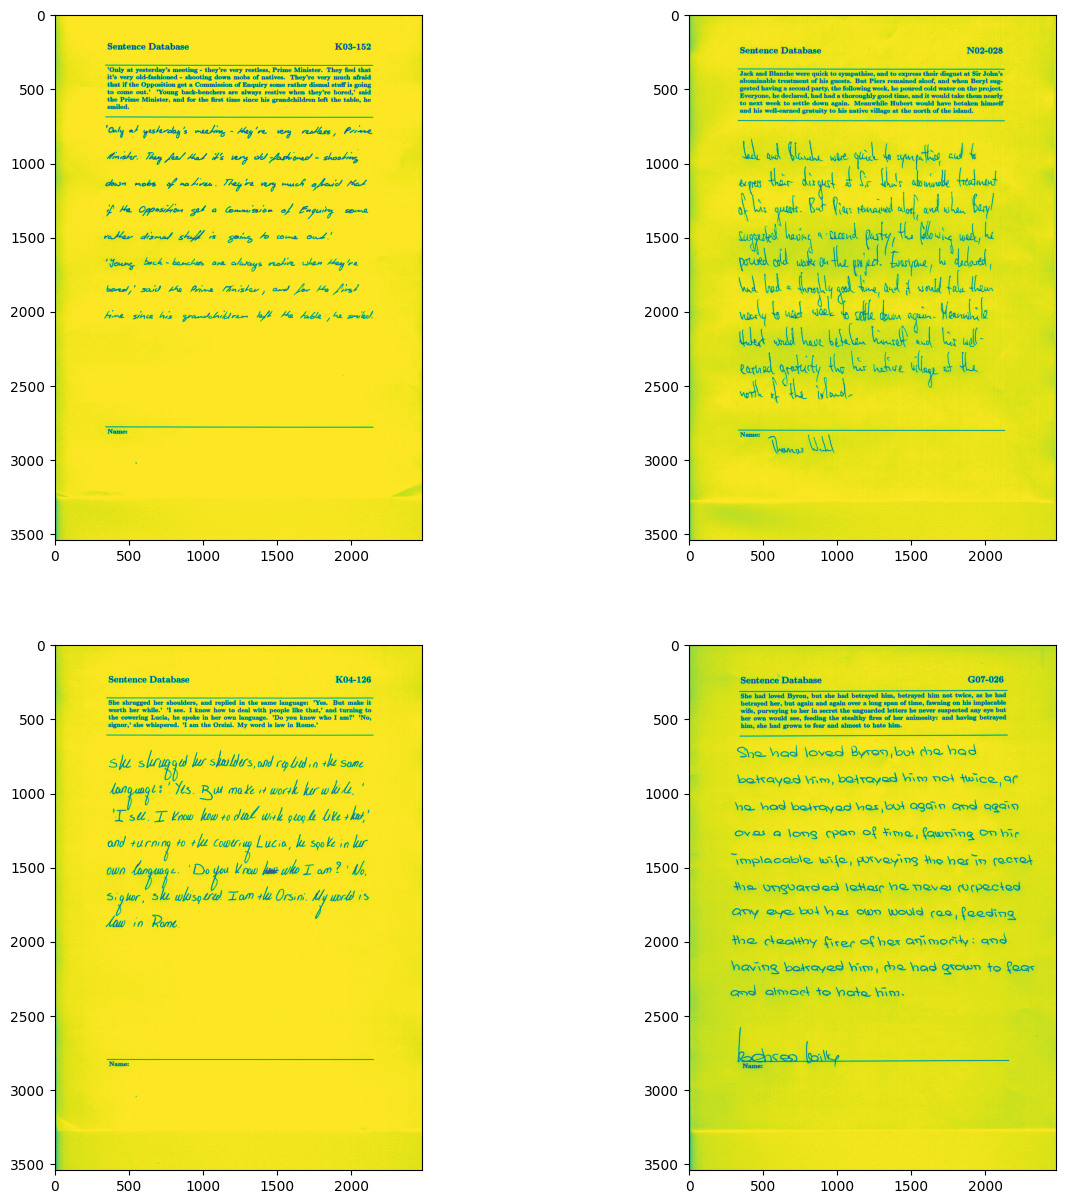

In [4]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Display the first form in the top-left subplot
axs[0, 0].imshow(forms[0])

# Display the second form in the top-right subplot
axs[0, 1].imshow(forms[1])

# Display the third form in the bottom-left subplot
axs[1, 0].imshow(forms[2])

# Display the fourth form in the bottom-right subplot
axs[1, 1].imshow(forms[3])

# Show the plot
plt.show()


<h2> 2.2. EMNIST Data</h2>

In [5]:
def extract_labels(filename):
    with gzip.open(filename, 'rb') as f:
        magic = int.from_bytes(f.read(4), byteorder='big')
        if magic != 2049:
            raise ValueError("Invalid magic number for label file: expected 2049, but got {}".format(magic))
        num_labels = int.from_bytes(f.read(4), byteorder='big')
        buf = f.read(num_labels)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

def extract_data(filename):
    with gzip.open(filename, 'rb') as f:
        # Read magic number and number of images
        magic = int.from_bytes(f.read(4), byteorder='big')
        if magic != 2051:
            raise ValueError("Invalid magic number for image file: expected 2051, but got {}".format(magic))
        num_images = int.from_bytes(f.read(4), byteorder='big', signed=False)

        # Read number of rows and columns
        rows = int.from_bytes(f.read(4), byteorder='big')
        cols = int.from_bytes(f.read(4), byteorder='big')

        # Read image data
        buf = f.read(num_images * rows * cols)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, rows, cols, 1)

        return data

train_images = extract_data('gzip/emnist-byclass-train-images-idx3-ubyte.gz')
train_labels = extract_labels('gzip/emnist-byclass-train-labels-idx1-ubyte.gz')

# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0

# Print the shape of the training images and labels
print("Training Images Shape: ", train_images.shape)
print("Training Labels Shape: ", train_labels.shape)


Training Images Shape:  (697932, 28, 28, 1)
Training Labels Shape:  (697932,)


In [6]:
import pandas as pd

# Create a DataFrame from the images and labels
Emnist_df = pd.DataFrame({
    'image': [img.reshape(28*28) for img in train_images],
    'label': train_labels.flatten()
})

# Show in  Pandas
Emnist_df.head()

,image,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",35
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",36
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22


<h3> 2.2.1. Visualize EMNIST

In [7]:
# # Reduce the dimensionality of the data to 2 using PCA
# pca = PCA(n_components=2)
# train_images_2d = pca.fit_transform(train_images.reshape(697932, -1))

# # Plot the 2D embeddings with color-coded labels
# plt.scatter(train_images_2d[:, 0], train_images_2d[:, 1], c=train_labels.flatten(), cmap='tab20')
# plt.colorbar()
# plt.show()


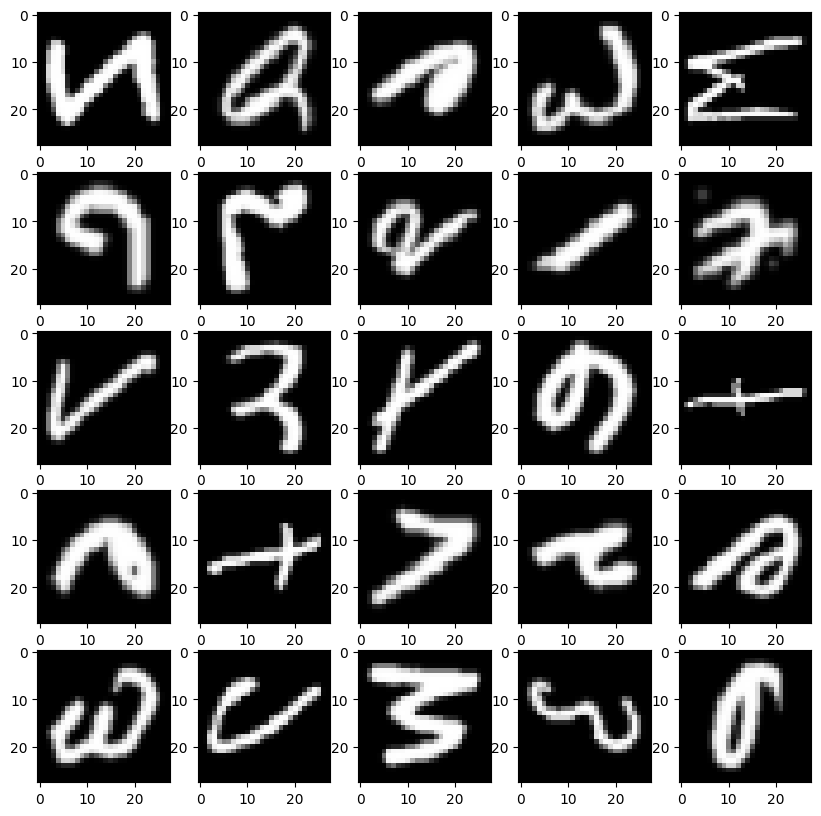

In [8]:
# Create a 5x5 grid of images from the training set
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(train_images[i*5+j].reshape(28, 28), cmap='gray')
plt.show()


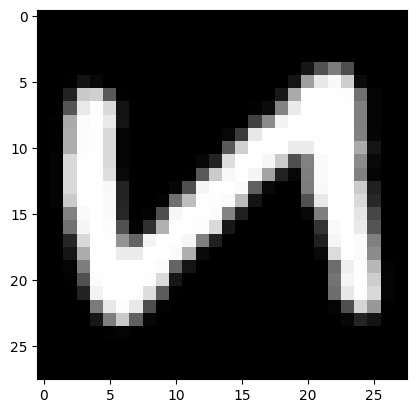

In [9]:
# Display the first image in the training set
plt.imshow(train_images[0].reshape(28, 28), cmap='gray')
plt.show()


<h1> 3. Data Preprocessing

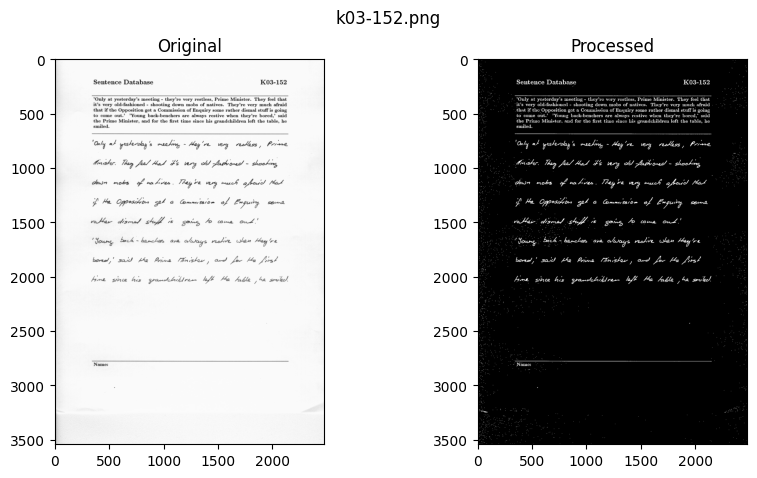

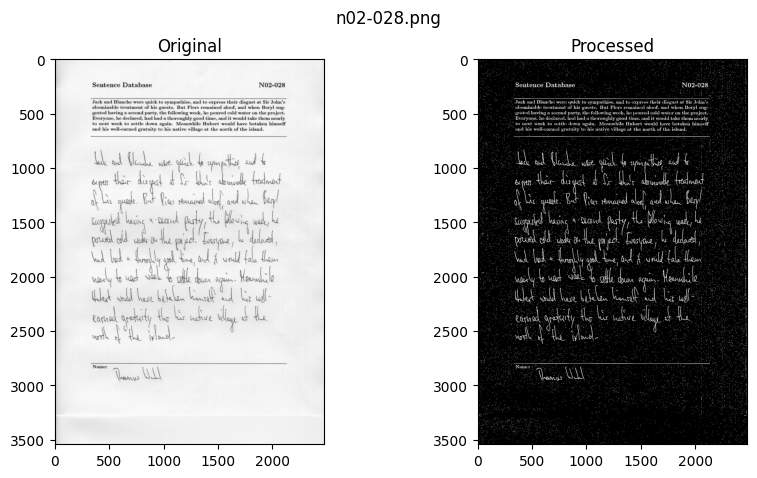

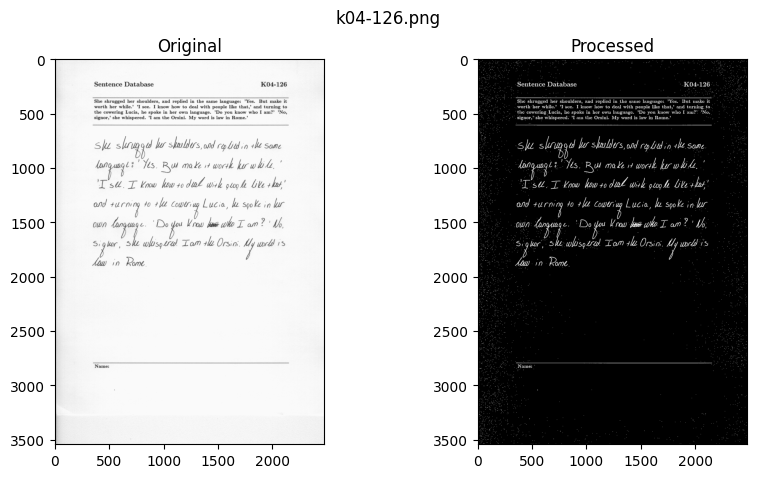

In [12]:
# Set the path to the dataset directory
forms_dir = '/home/munyao/Desktop/flat_iron_school/Moringa/phase_5/IAM'

# Load all the PNG images in the forms subdirectory
form_files = os.listdir(os.path.join(forms_dir, 'forms'))[:3]
for form_file in form_files:
    # Load the form image
    form_path = os.path.join(forms_dir, 'forms', form_file)
    form_image = cv2.imread(form_path)

    # Convert the image to grayscale
    form_image_gray = cv2.cvtColor(form_image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to the image to extract the text regions
    form_image_thresh = cv2.adaptiveThreshold(form_image_gray, 255, 
                                              cv2.ADAPTIVE_THRESH_MEAN_C, 
                                              cv2.THRESH_BINARY_INV, 11, 2)

    # Apply morphological transformations to the image to clean up noise
    kernel = np.ones((3,3),np.uint8)
    form_image_open = cv2.morphologyEx(form_image_thresh, cv2.MORPH_OPEN, kernel)
    form_image_close = cv2.morphologyEx(form_image_open, cv2.MORPH_CLOSE, kernel)

    # Perform text detection using pytesseract
    text_1 = pytesseract.image_to_string(form_image_close, lang='eng')
    
    # Display the original image and the processed image side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(cv2.cvtColor(form_image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(form_image_close, cmap='gray')
    axs[1].set_title('Processed')
    plt.suptitle(form_file)
    plt.show()

>The image is made dark so that it is easier for a computer to tell what is writing and what is background. This makes it easier for the computer to recognize the words written on the paper.